## **Definición**

Un diagrama de interacción de una columna es una curva compuesta de puntos cuyas coordenadas son la carga axial nominal $P_n$ y el momento nominal $M_n$. Esta herramienta es muy utilizada por los ingenieros ya que es muy útil para analizar la resistencia de una sección de columna que estará sometida a las solicitaciones de carga.

<p align="center">
    <img src="https://github.com/Niccolas-Villegas/Diagrama-Interaccion/blob/main/Figura1.png?raw=true" alt="Diagrama de Interacción" width="500" height="500"/>
</p>

## **Procedimiento**

Teniendo en cuenta que trabajamos dentro del rango lineal, se considera lo siguiente:
- La resistencia nominal de la sección se alcanza cuando la deformación unitaria en la fibra extrema en compresión es igual a 0.003.
- Las deformaciones unitaria de tracción en el refuerzo extremo se determina a partir de una distribución de deformaciones unitarias lineal en el estado de resistencia nominal.

<p align="center">
  <img src="https://github.com/Niccolas-Villegas/Diagrama-Interaccion/blob/main/Figura2.png?raw=true" alt="Grafico de seccion">
</p>

Con los puntos mencionados, se pueden obtener las resistencias nominales de la sección de columna realizando los siguientes pasos:

1. Se elige un valor para la distancia del borde extremo a compresión hacia el eje neutro "$c$". Posteriormente, se calcula el valor de profundidad del bloque de compresiones "$a$".

    $$
    a = \beta_1 c
    $$

2. Calculamos los esfuerzos del concreto y el acero de refuerzo para obtener sus fuerzas respectivas.

    <u>Deformación para el acero de refuerzo</u>:

    $$
    \varepsilon_{s_i} = \frac{0.003(c-y_i)}{c} \quad  \quad \left\{
    \begin{array}{lcc}
        \text{si} \quad \varepsilon_{s_i} < \varepsilon_y \quad \rightarrow \quad f_{s_i} = \varepsilon_{s_i} E_s \\
        \\
        \quad
        \quad
        \\
        \text{si} \quad \varepsilon_{s_i} \geq \varepsilon_y \quad \rightarrow \quad f_{s_i} = f_y
    \end{array}
    \right.
    $$

    <u>Fuerza del concreto</u>:

    $$
    F_c = 0.85f'_c a b
    $$

    <u>Fuerza del acero de refuerzo</u>:

    $$
    F_s = \sum_{i=1}^{m} f_{s_i} A_{s_i}
    $$

3. Con las ecuaciones de equilibrio, obtenemos valores de $P_n$ y $M_n$ que representan un punto de la curva a obtener.

    $$
    P_n = 0.85f'_c a b + \sum_{i=1}^{m} f_{s_i} A_{s_i}
    \\
    \quad
    \\
    M_n = 0.85f'_cab(c_p - y_c) + \sum_{i=1}^{m} f_{s_i} A_{s_i} (c_p - y_i)
    $$
    
    Para sección rectangular:
    
    $$
    c_p = \frac{h}{2} \quad \quad    ,     \quad \quad  y_c = \frac{a}{2}
    \\
    \quad
    \\
    $$

4. Se repite el proceso para otro valor de “$c$” y obtener nuevas coordenadas $(M_n,P_n)$.

## **Código de programación**

Mediante el uso de la programación es posible realizar los cálculos iterativos de manera rápida y eficaz. A continuación, se muestra un código realizado en Python para la obtención de la gráfica del diagrama de interacción nominal y reducidos considerando la normativa ACI 318-19 y la normativa peruana E060.

### **Importación de librerias**

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### **Definición de unidades**

In [67]:
# Unidades MKS
m = 1
cm = 0.01*m
mm = 0.001*m

kgf = 1
tnf = 1000*kgf

### **Creación de clase de propiedades del acero de refuerzo**

In [68]:
class rebar:
    def __init__(self, B):
        self.B = B
    
    def diametro(self, db):
        '''
        Determina el diametro del acero longitudinal 
        segun su numero de barra
        '''
        if db == 2:
            db = 6.4*mm
        elif db == 3:
            db = 9.5*mm
        elif db == 4:
            db = 12.7*mm
        elif db == 5:
            db = 15.9*mm
        elif db == 6:
            db = 19.1*mm
        elif db == 8:
            db = 25.4*mm
        else:
            db = 0.00
        return db

    def area(self, db):
        '''
        Determina el area del acero longitudinal 
        segun su numero de barra
        '''
        if db == 2:
            As = 0.32*cm**2
        elif db == 3:
            As = 0.71*cm**2
        elif db == 4:
            As = 1.27*cm**2
        elif db == 5:
            As = 1.98*cm**2
        elif db == 6:
            As = 2.84*cm**2
        elif db == 8:
            As = 5.10*cm**2
        else:
            As = 0.00
        return As
    
    def As(self):
        '''
        Determina el area del acero de refuerzo por 
        cada tramo de barras segun la direccion analizada
        '''
        nbx, nby = self.B.shape
        A = np.zeros((nbx, nby))
        for i in range(nbx):
            for j in range(nby):
                A[i][j] = self.area(self.B[i][j])
        return A

### **Creacion de clase de variables segun normativas consideradas**

In [69]:
class variables_generales:
    # Segun ACI 318-19 - Tabla 22.2.2.4.3.
    def fs_valor(self, es):
        Es = (2*10**6)*kgf/cm**2
        if es > 0.0021:
            fs = 4200*kgf/cm**2
        elif es < -0.0021:
            fs = -4200*kgf/cm**2
        else:
            fs = Es*es
        return fs
    
    # Segun ACI 318-19 - Tabla 22.2.2.4.3.
    def beta(self, fc):
        if 175*kgf/cm**2 <= fc <= 280*kgf/cm**2:
            beta = 0.85
        elif 280*kgf/cm**2 < fc < 550*kgf/cm**2:
            beta = 0.85 - 0.05*(self.fc-280*kgf/cm**2)/70*kgf/cm**2
        elif fc > 550*kgf/cm**2:
            beta = 0.65
        return beta

### **Creación de clase para el diagrama de interacción**

In [70]:
class Diagrama_Interaccion_Rect:
    def __init__(self, b, h, rec, d_est, fc, fy, Rebar, P_dem, Mx_dem, My_dem):
        self.b = b
        self.h = h
        self.bo = b
        self.ho = h
        self.rec = rec
        self.d_est = d_est
        self.fc = fc
        self.fy = fy
        self.Rebar = Rebar
        self.P_dem = P_dem
        self.Mx_dem = Mx_dem
        self.My_dem = My_dem
        
        for eje in ['X','Y']:
            self.ubicacion, self.As = self.direccion(eje)
            if eje == 'X':
                self.y_loc = self.ubicacion
                self.Pnx, self.Mnx = self.curva_reducida()[0:2]
                self.ACI_Pnx, self.ACI_Mnx = self.curva_reducida()[2:4]
                self.E060_Pnx, self.E060_Mnx = self.curva_reducida()[4:6]
                self.Pbx, self.Mbx = self.zona_balance()
            else:
                self.x_loc = self.ubicacion
                self.Pny, self.Mny = self.curva_reducida()[0:2]
                self.ACI_Pny, self.ACI_Mny = self.curva_reducida()[2:4]
                self.E060_Pny, self.E060_Mny = self.curva_reducida()[4:6]
                self.Pby, self.Mby = self.zona_balance()
    
    def direccion(self, eje):
        '''
        Reorienta los inputs para obtener el diagrama 
        de interaccion en la direccion a analizar
        '''            
        if eje == 'X':
            barras = np.max(self.Rebar, axis=1)
            As = np.sum(rebar(self.Rebar).As(), axis=1)
            n_capas = self.Rebar.shape[0]
        elif eje == 'Y':
            barras = np.max(self.Rebar, axis=0)
            As = np.sum(rebar(self.Rebar).As(), axis=0)
            self.b, self.h = self.h, self.b
            n_capas = self.Rebar.shape[1]
        d_barras = [rebar(self.Rebar).diametro(db) for db in barras]
        valor_fijo = self.h - 2*self.rec - 2*self.d_est
        espacio = (valor_fijo - np.sum(d_barras))/(n_capas-1)
        ubicacion = []
        for i in range(len(d_barras)):
            sum_barras = np.sum(d_barras[:i]) + d_barras[i]/2
            y = self.rec + self.d_est + sum_barras + i*espacio
            ubicacion.append(y)
        return ubicacion, As
    
    # Factor de reduccion segun ACI 318-19 - Tabla 21.2.2.
    def phi_ACI(self, es):
        '''
        Determina el factor de reduccion segun la norma ACI 318-19
        es: deformacion unitaria del refuerzo mas cercano a la cara en traccion 
        '''
        ety = 0.0021
        if abs(es) <= 0.0021:
            phi = 0.65
        elif 0.0021 < abs(es) <= 0.005:
            phi = 0.65 + 0.25*(abs(es)-ety)/(0.005-ety)
        else:
            phi = 0.90
        return phi
    
    # Factor de reduccion segun E.060 - Articulo 9.3.2.2.
    def phi_E060(self, Pn):
        '''
        Determina el factor de reduccion segun la norma E060
        Nota: Se aproximo el peralte efectivo como la altura menos 6cm
        Pn: Carga axial que se encuentra en Pmin y 0
        '''
        ety = 0.0021
        cb = (self.h-6*cm)/(1 + ety/0.003)
        Pnb = self.curva_nominal(cb)[0]
        Pmin = min((0.1*self.fc*self.b*self.h)/(0.7*tnf), Pnb)
        if Pn > Pmin:
            phi = 0.70
        elif Pn < 0:
            phi = 0.90
        else:
            phi = 0.90 - (0.90-0.70)*Pn/Pmin
        return phi
    
    def limites(self):
        '''
        Define los limites a compresion y traccion del diagrama de interaccion
        '''
        Pon = (0.85*self.fc*(self.b*self.h-sum(self.As)) + self.fy*sum(self.As))
        Tn = -self.fy*sum(self.As)
        return Pon/tnf, Tn/tnf

    def curva_nominal(self, c):
        beta = variables_generales().beta(self.fc)
        a = beta*c
        Fc = 0.85*self.fc*a*self.b
        sumFs, sumMs = 2*[0]
        for i in range(len(self.ubicacion)):
            es = 0.003*(c - self.ubicacion[i])/c
            fs = variables_generales().fs_valor(es)
            Fs = self.As[i]*fs
            sumFs = sumFs + Fs
            sumMs = sumMs + Fs*(self.h/2 - self.ubicacion[i])
        Pn = Fc + sumFs
        Mn = Fc*(self.h - a)/2 + sumMs
        return Pn/tnf, Mn/(tnf*m)

    def curva_ACI(self, c, Pn, Mn):
        '''
        Multiplica Pn y Mn por el factor phi
        según normativa ACI 318-19
        '''
        et = 0.003*(c - max(self.ubicacion))/c
        phi = self.phi_ACI(et)
        return phi*Pn, phi*Mn
    
    def curva_E060(self, Pn, Mn):
        '''
        Multiplica Pn y Mn por el factor phi
        según normativa E060
        '''
        phi = self.phi_E060(Pn)
        return phi*Pn, phi*Mn

    def curva_reducida(self):
        # Se inicia la lista de curvas con estos valores para 
        # cerrar los diagramas de interaccion
        Pon, Tn = self.limites()
        Pn_max = 0.80*Pon
        ACI_Pn_max = 0.65*Pn_max
        E060_Pn_max = 0.70*Pn_max
        Pnt = [Tn] + 2*[Pn_max]
        Mnt = 2*[0]
        ACI_Pnt = [0.90*Tn] + 2*[ACI_Pn_max]
        ACI_Mnt = 2*[0] 
        E060_Pnt = [0.90*Tn] + 2*[E060_Pn_max]
        E060_Mnt = 2*[0]
        
        # Obtencion de los diagramas de interaccion 
        # nominal y reducido (segun normativas)
        i = 1
        for c in np.linspace(1*cm, self.h, 30):
            Pn, Mn = self.curva_nominal(c)
            if Pn < Pn_max:
                Pnt.insert(i, Pn)
                Mnt.insert(i ,Mn)
                ACI_Pn, ACI_Mn = self.curva_ACI(c, Pn, Mn)
                ACI_Pnt.insert(i, ACI_Pn)
                ACI_Mnt.insert(i, ACI_Mn)
                E060_Pn, E060_Mn = self.curva_E060(Pn, Mn)
                E060_Pnt.insert(i, E060_Pn)
                E060_Mnt.insert(i, E060_Mn)
                i += 1
        
        # Interpolacion lineal para cerrar los diagramas de interaccion en Pn_max
        Mnf = Mnt[i-1] + (Mnt[i-1]-Mnt[i-2])/(Pnt[i-1]-Pnt[i-2])*(Pn_max-Pnt[i-1])
        Mnt.insert(i ,Mnf)
        ACI_Mnt.insert(i, 0.65*Mnf)
        E060_Mnt.insert(i, 0.70*Mnf)
        
        return Pnt, Mnt, ACI_Pnt, ACI_Mnt, E060_Pnt, E060_Mnt
    
    def zona_balance(self):
        '''
        Determina la zona de trancision o falla balanceada de la seccion
        Nota: Se aproximo el peralte efectivo como la altura menos 6cm
        '''
        ety = 0.0021
        cb = (self.h-6*cm)/(1 + ety/0.003)
        Pnb, Mnb = self.curva_nominal(cb)
        Pb = [Pnb, 0, Pnb]
        Mb = [-Mnb, 0, Mnb]
        
        return Pb, Mb
    
    def Ploteos(self):
        Pnx = self.Pnx + self.Pnx[::-1]
        Pny = self.Pny + self.Pny[::-1]
        Mnx = self.Mnx + [-x for x in self.Mnx][::-1]
        Mny = self.Mny + [-y for y in self.Mny][::-1]
        ACI_Pnx = self.ACI_Pnx + self.ACI_Pnx[::-1]
        ACI_Pny = self.ACI_Pny + self.ACI_Pny[::-1]
        ACI_Mnx = self.ACI_Mnx + [-x for x in self.ACI_Mnx][::-1]
        ACI_Mny = self.ACI_Mny + [-y for y in self.ACI_Mny][::-1]
        E060_Pnx = self.E060_Pnx + self.E060_Pnx[::-1]
        E060_Pny = self.E060_Pny + self.E060_Pny[::-1]
        E060_Mnx = self.E060_Mnx + [-x for x in self.E060_Mnx][::-1]
        E060_Mny = self.E060_Mny + [-y for y in self.E060_Mny][::-1]
        
        # # Extracción de resultados
        # data1 = {'Pnx':Pnx, 'Mnx':Mnx, 'phi_Pnx':ACI_Pnx, 'phi_Mnx':ACI_Mnx}
        # df1 = pd.DataFrame(data1)
        # df1.to_csv('Resultados_x.csv')
        # data2 = {'Pny':Pny, 'Mny':Mny, 'phi_Pny':ACI_Pny, 'phi_Mny':ACI_Mny}
        # df2 = pd.DataFrame(data2)
        # df2.to_csv('Resultados_y.csv')

        
        fig, axs = plt.subplots(1, 2, figsize =(20,12))
        plt.rcParams['font.family'] = 'Segoe UI'    

        # Grafico de diagrama de interaccion en eje X
        axs[0].plot(Mnx, Pnx, 'k', 
                    ACI_Mnx, ACI_Pnx, 'b', 
                    E060_Mnx, E060_Pnx, 'r')
        axs[0].plot(self.Mbx, self.Pbx, linestyle='--', color='silver') 
        for i in range(len(self.P_dem)):
            axs[0].plot(self.Mx_dem[i], self.P_dem[i], 'gx', markersize = 12)
        axs[0].legend(['Capacidad Nominal', 'Capacidad ACI 318-19', 
                       'Capacidad E060', 'Falla balanceada', 
                       'Demanda'], loc='lower right')
        axs[0].set_title('Diagrama de Interaccion - Eje X', size = 15)
        axs[0].grid(color = 'silver')
        axs[0].set_xlabel('Momento $ton.m$', size = 10)
        axs[0].set_ylabel('Carga Axial $ton$', size = 10)

        # Grafico de diagrama de interaccion en eje Y
        axs[1].plot(Mny, Pny, 'k', 
                    ACI_Mny, ACI_Pny, 'b', 
                    E060_Mny, E060_Pny, 'r')
        axs[1].plot(self.Mby, self.Pby, linestyle='--', color='silver') 
        for i in range(len(self.P_dem)):
            axs[1].plot(self.My_dem[i], self.P_dem[i], 'gx', markersize = 12)
        axs[1].legend(['Capacidad Nominal', 'Capacidad ACI 318-19', 
                       'Capacidad E060', 'Falla balanceada', 
                       'Demanda'], loc='lower right')
        axs[1].set_title('Diagrama de Interaccion - Eje Y', size = 15)
        axs[1].grid(color = 'silver')
        axs[1].set_xlabel('Momento $ton.m$', size = 10)
        axs[1].set_ylabel('Carga Axial $ton$', size = 10)

        return plt.show()

### **Ejemplo de Aplicación**

Realizado el código, se procede a correr con datos de ejemplo de una sección típica de columna de concreto.

In [71]:
# Geometría de la sección
b = 30*cm
h = 60*cm
rec = 4*cm
d_est = 9.5*mm

# Propiedades del material
fc = 280*kgf/cm**2
fy = 4200*kgf/cm**2

# Distribución del acero de refuerzo
Rebar = np.array([[8, 8, 8, 8],
                  [8, 0, 0, 8],
                  [8, 8, 8, 8]])

# Solicitaciones de carga (tnf)
P_dem = [150, -100, 50, 0]
Mx_dem = [20, -15.5, -36, 30]
My_dem = [10, -2, 8, -15]

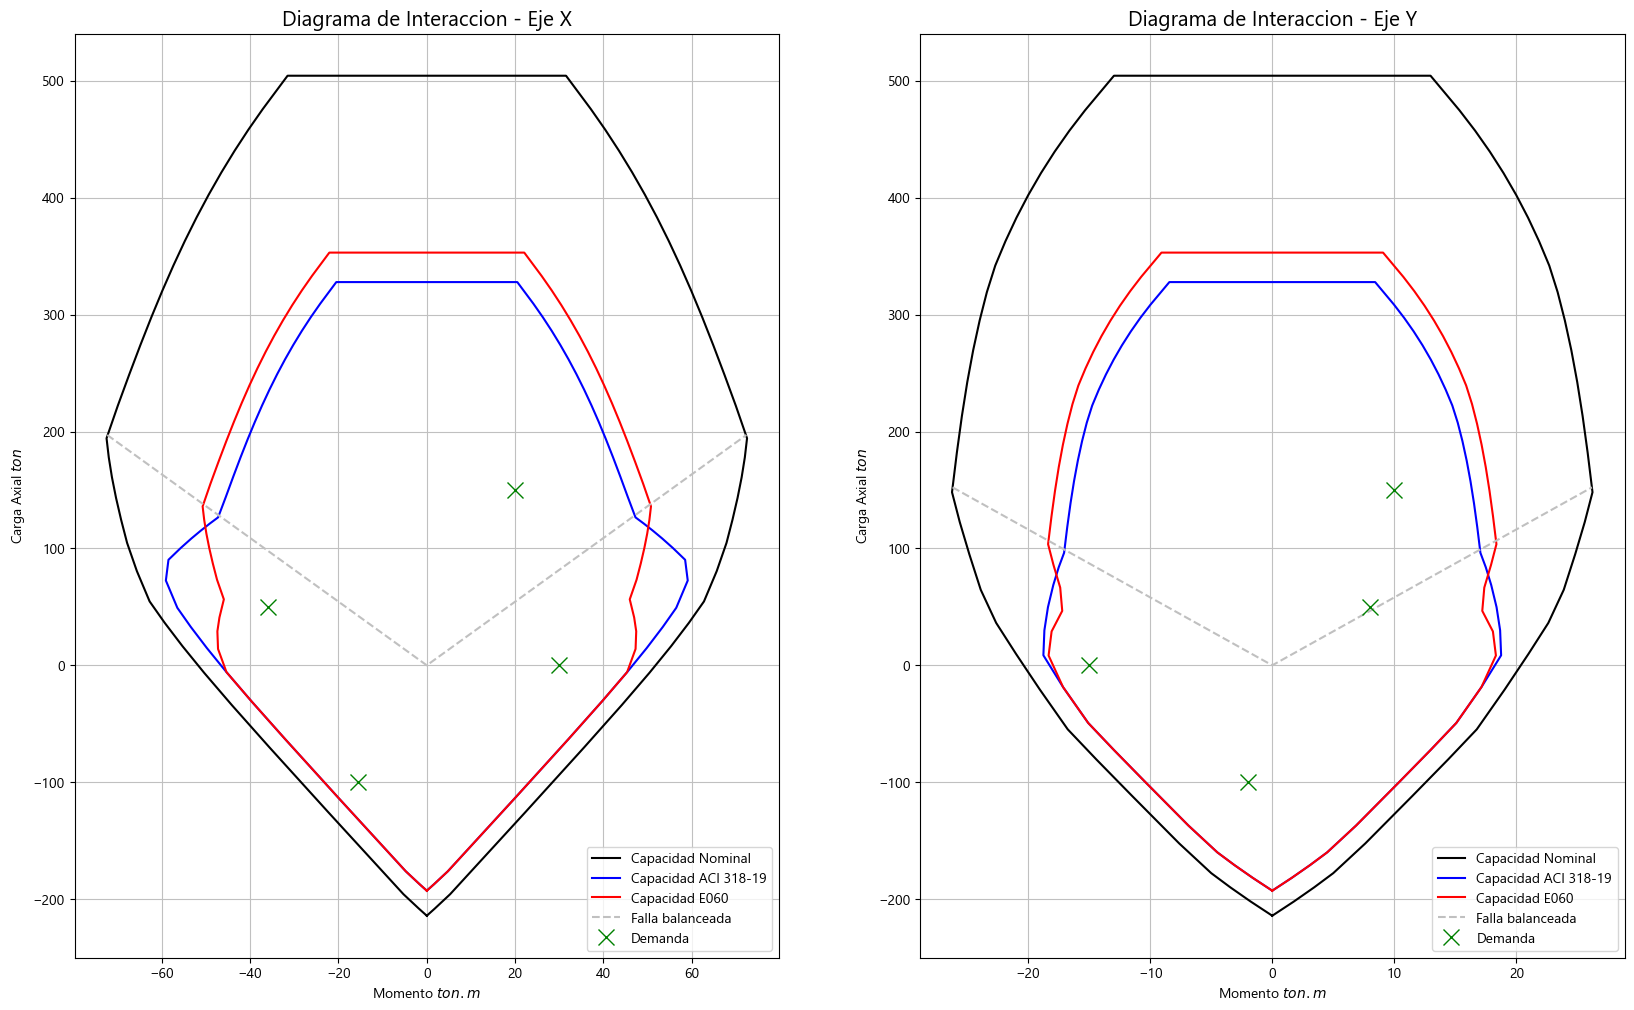

In [72]:
x = Diagrama_Interaccion_Rect(b, h, rec, d_est, fc, fy, Rebar,
                              P_dem, Mx_dem, My_dem)
x.Ploteos()

## **Comparación Python vs ETABS**

Haciendo uso del software ETABS, creamos la sección con las mismas dimensiones y propiedades para obtener el diagrama de interacción según la normativa ACI 318-19. Haciendo uso de la librería Pandas, se extraen los datos de las curva graficadas en Python (esta sección se encuentra comentada dentro del código).

<p align="center">
    <img src="https://github.com/Niccolas-Villegas/Diagrama-Interaccion/blob/main/Figura3.png?raw=true" alt="ETABS" width="1200" height="500"/>
</p>

Con los resultados obtenidos, se compara los diagramas obtenidos en ambos casos.

<u>Eje X-X</u>:

<p align="center">
    <img src="https://github.com/Niccolas-Villegas/Diagrama-Interaccion/blob/main/Figura4.png?raw=true" alt="Diagrama Nominal" width="1200" height="500"/>
</p>

<u>Eje Y-Y</u>:

<p align="center">
    <img src="https://github.com/Niccolas-Villegas/Diagrama-Interaccion/blob/main/Figura5.png?raw=true" alt="Diagrama Reducido" width="1200" height="500"/>
</p>

Observamos que los diagramas son cercanos entre sí, mostrando la eficiencia del código realizado. Bajo este mismo procedimiento se puede plantear el cálculo para secciones de diferente geometría como secciones L, circulares, T, etc.